<a href="https://colab.research.google.com/github/jakub-porowski/DL-OWN/blob/main/FinalApp.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Import bibliotek**

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import accuracy_score
from xgboost import XGBClassifier
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

!pip install pycountry
import seaborn as sns
import pycountry as pc
import matplotlib.ticker as mtick
pd.options.display.max_columns = None

     |████████████████████████████████| 10.1MB 8.4MB/s 
  Created wheel for pycountry: filename=pycountry-20.7.3-py2.py3-none-any.whl size=10746865 sha256=fc79d7c16a9646a9ddce8ceb31ab509021e47f742261f57ea88672a244920401
  Stored in directory: /root/.cache/pip/wheels/33/4e/a6/be297e6b83567e537bed9df4a93f8590ec01c1acfbcd405348
Successfully built pycountry


**Wczytanie danych do eksploracji/analizy**

In [3]:
url = 'https://raw.githubusercontent.com/jakub-porowski/DL-OWN/main/hotel_bookings.csv'
data1 = pd.read_csv(url)
data1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 119390 entries, 0 to 119389
Data columns (total 32 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   hotel                           119390 non-null  object 
 1   is_canceled                     119390 non-null  int64  
 2   lead_time                       119390 non-null  int64  
 3   arrival_date_year               119390 non-null  int64  
 4   arrival_date_month              119390 non-null  object 
 5   arrival_date_week_number        119390 non-null  int64  
 6   arrival_date_day_of_month       119390 non-null  int64  
 7   stays_in_weekend_nights         119390 non-null  int64  
 8   stays_in_week_nights            119390 non-null  int64  
 9   adults                          119390 non-null  int64  
 10  children                        119386 non-null  float64
 11  babies                          119390 non-null  int64  
 12  meal            

**Eksploracja i analiza danych**

In [ ]:
df = data1.copy()
df.isnull().sum().sort_values(ascending=False)[:10]

In [5]:
## Zastąpienie NaN w id company oraz agent zerami
df[['agent','company']] = df[['agent','company']].fillna(0.0)

## Zastąpienie brakujących wartości w kolumnie country modą
df['country'].fillna(data1.country.mode().to_string(), inplace=True)

## Zastąpienie brakujących wartości w kolumnie children średnią
df['children'].fillna(round(data1.children.mean()), inplace=True)

## Usunięcie wierszy z wartością zero w kolumnach adults, babies, children
df = df.drop(df[(df.adults+df.babies+df.children)==0].index)

## Zamiana typów float na int
df[['children', 'company', 'agent']] = df[['children', 'company', 'agent']].astype('int64')

In [6]:
## Funkcja do przygotowania danych procentowych
def get_count(series, limit=None):
    if limit != None:
        series = series.value_counts()[:limit]
    else:
        series = series.value_counts()
        
    x = series.index
    y = series/series.sum()*100
    return x.values,y.values

## Funkcja do generowania wykresów
def plot(x, y, x_label=None,y_label=None, title=None, figsize=(7,5), type='bar'):
    sns.set_style('darkgrid')
    fig, ax = plt.subplots(figsize=figsize)
    ax.yaxis.set_major_formatter(mtick.PercentFormatter())
    
    if x_label != None:
        ax.set_xlabel(x_label)
    
    if y_label != None:
        ax.set_ylabel(y_label)
        
    if title != None:
        ax.set_title(title)
    
    if type == 'bar':
        sns.barplot(x,y, ax = ax)
    elif type == 'line':
        sns.lineplot(x,y, ax = ax, sort=False)
    plt.show()

In [ ]:
## Przygotowanie danych dla zbadania udziału odwołanych i nieodwołanych rezerwacji
x, y = get_count(df['is_canceled'])
x, y

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


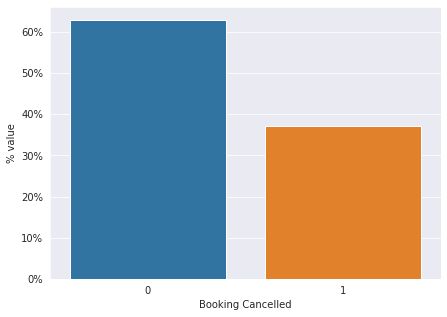

In [8]:
## Wykres przedstawiający udział procentowy odwołanych i nieodwołanych rezerwacji
plot(x, y, x_label='Booking Cancelled', y_label='% value')
## 37% rezerwacji zostało odwołanych

In [14]:
## Analiza dla rezerwacji nieodwołanych
df_not_canceled = df[df['is_canceled'] == 0]
## Analiza dla rezerwacji odwołanych
df_canceled = df[df['is_canceled'] == 1]

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


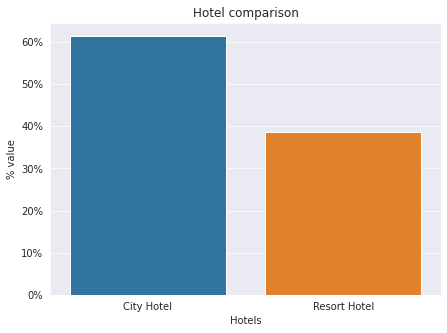

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


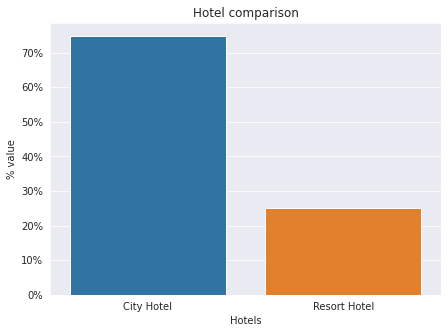

In [15]:
## Przygotowanie danych i generowanie wykresu udziału procentowego typów hoteli (nieodwołana rezerwacja)
x, y = get_count(df_not_canceled['hotel'])
plot(x,y, x_label='Hotels', y_label='% value', title='Hotel comparison')
## Ponad 60% rezerwacji dotyczy hoteli miejskich


## Przygotowanie danych i generowanie wykresu udziału procentowego typów hoteli (odwołana rezerwacja)
x, y = get_count(df_canceled['hotel'])
plot(x,y, x_label='Hotels', y_label='% value', title='Hotel comparison')
## 75% rezerwacji dotyczy hoteli miejskich

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


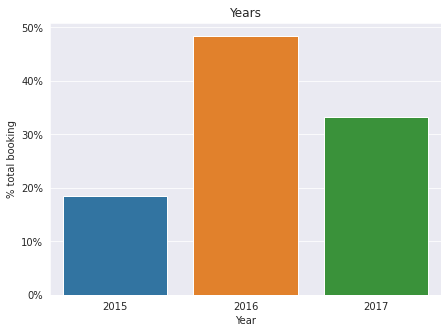

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


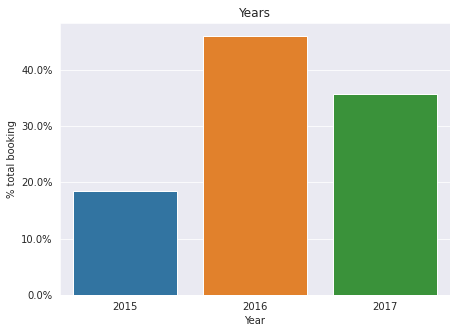

In [16]:
## Przygotowanie danych i generowanie wykresu udziału procentowego rezerwacji w poszczególnych latach
x, y = get_count(df_not_canceled['arrival_date_year'])
plot(x, y, x_label = 'Year', y_label = '% total booking', title = 'Years')
## Prawie połowa rezerwacji dokonana w 2016 roku
## Spadek ilości rezerwacji o prawie 30% w roku 2017


## Przygotowanie danych i generowanie wykresu udziału procentowego rezerwacji w poszczególnych latach
x, y = get_count(df_canceled['arrival_date_year'])
plot(x, y, x_label = 'Year', y_label = '% total booking', title = 'Years')
## Prawie połowa rezerwacji dokonana w 2016 roku
## Spadek ilości rezerwacji o blisko 20% w roku 2017

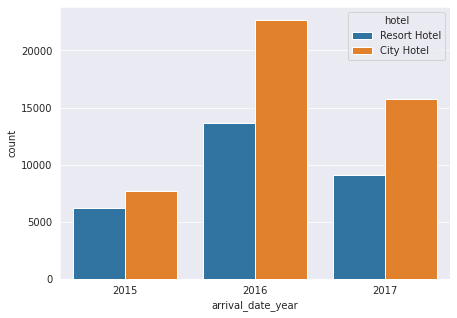

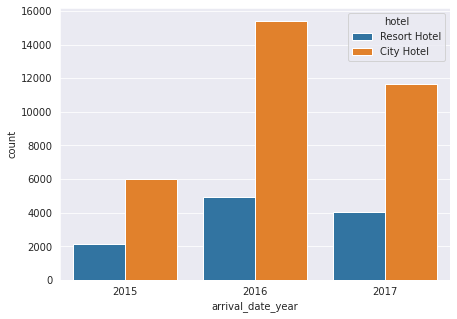

In [18]:
## Rozbicie na typy hoteli (nieodwołane)
plt.subplots(figsize = (7,5))
sns.countplot(x = 'arrival_date_year', hue = 'hotel', data = df_not_canceled);


## Rozbicie na typy hoteli (odwołane)
plt.subplots(figsize = (7,5))
sns.countplot(x = 'arrival_date_year', hue = 'hotel', data = df_canceled);

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


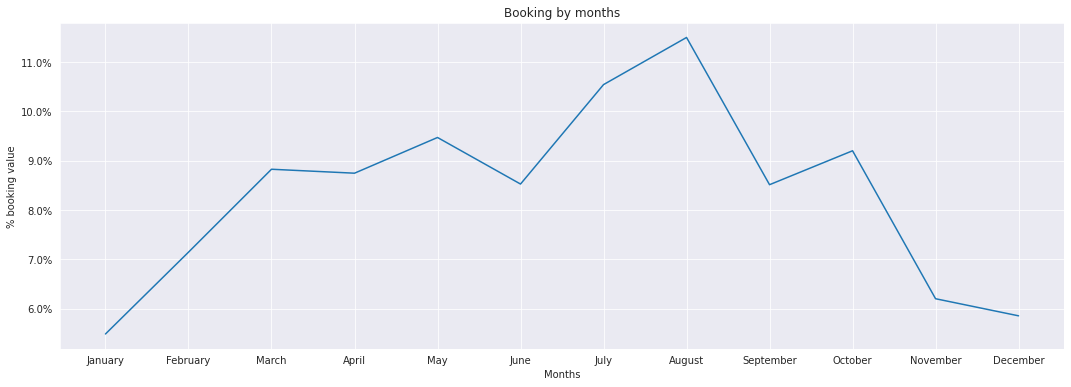

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


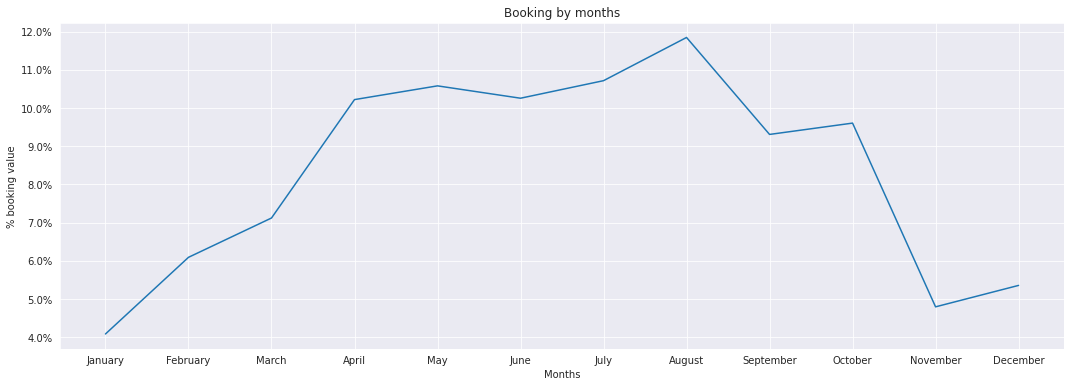

In [19]:
## Najbardziej oblegane miesiące (nieodwołane)
months = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September',
             'October', 'November', 'December']
sorted_months = df_not_canceled['arrival_date_month'].value_counts().reindex(months)

x = sorted_months.index
y = sorted_months/sorted_months.sum()*100

plot(x, y.values, x_label = 'Months', y_label = '% booking value', title = 'Booking by months', type = 'line', figsize = (18,6))
## Z wykresu wynika, że najwięcej rezerwacji dokonywano w lipcu i sierpniu


## Najbardziej oblegane miesiące (odwołane)
months = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September',
             'October', 'November', 'December']
sorted_months = df_canceled['arrival_date_month'].value_counts().reindex(months)

x = sorted_months.index
y = sorted_months/sorted_months.sum()*100

plot(x, y.values, x_label = 'Months', y_label = '% booking value', title = 'Booking by months', type = 'line', figsize = (18,6))
## Wykres w przybliżeniu pokrywa się z tym dla rezerwacji nieodwołanych

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


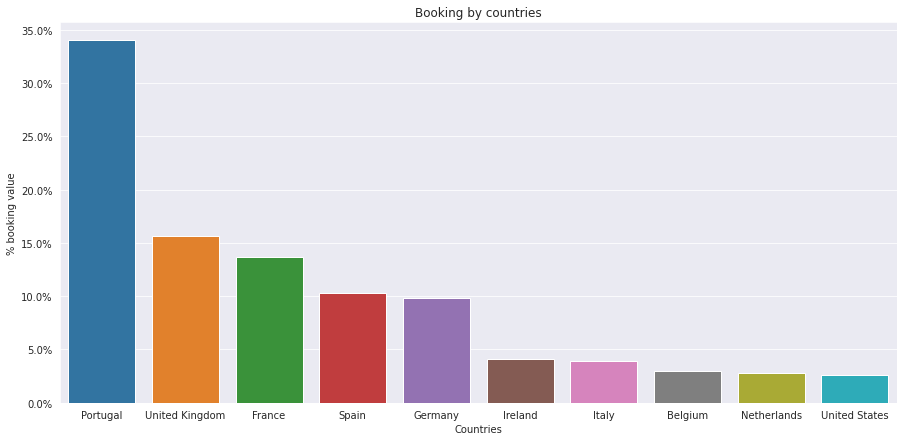

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


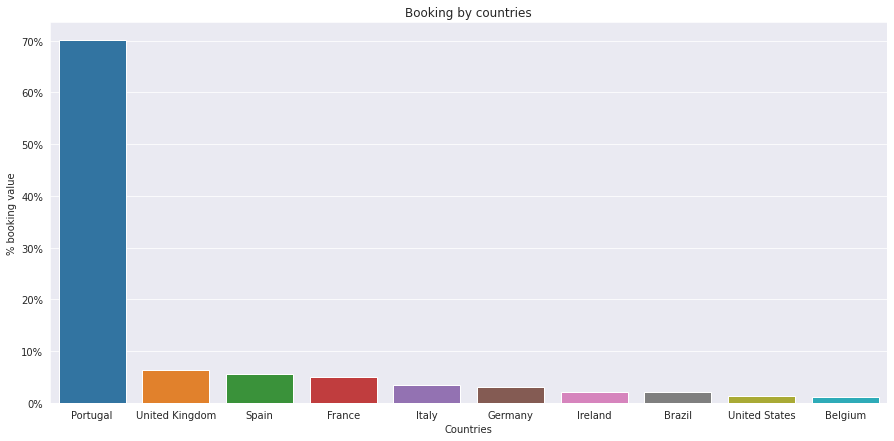

In [20]:
## Przygotowanie danych i generowanie wykresu udziału procentowego rezerwacji nieodwołanych w poszczególnych krajach
x, y = get_count(df_not_canceled['country'], limit = 10) ## Wprowadzenie parametru limit do funkcji get_count

## Wykorzystanie biblioteki pycountry dla zamiany kodów na nazwę kraju
country_name = [pc.countries.get(alpha_3 = name).name for name in x]

plot(country_name,y, x_label = 'Countries', y_label = '% booking value', title = 'Booking by countries', figsize = (15,7))
## Portugalia, UK, Francja, Hiszpania i Niemcy odpowiadają za ponad 80% rezerwacji


## Przygotowanie danych i generowanie wykresu udziału procentowego rezerwacji odwołanych w poszczególnych krajach
x, y = get_count(df_canceled['country'], limit = 10) ## Wprowadzenie parametru limit do funkcji get_count

## Wykorzystanie biblioteki pycountry dla zamiany kodów na nazwę kraju
country_name = [pc.countries.get(alpha_3 = name).name for name in x]

plot(country_name,y, x_label = 'Countries', y_label = '% booking value', title = 'Booking by countries', figsize = (15,7))
## Znakomita większość odwołanych dla Portugalii

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


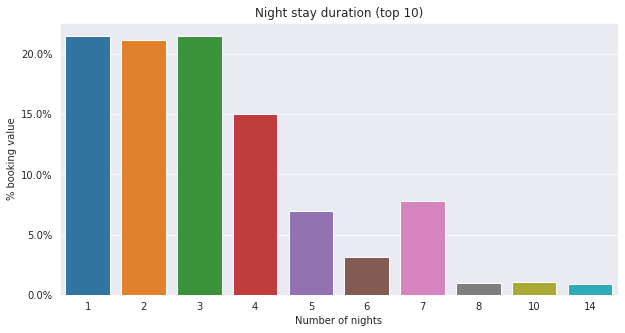

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


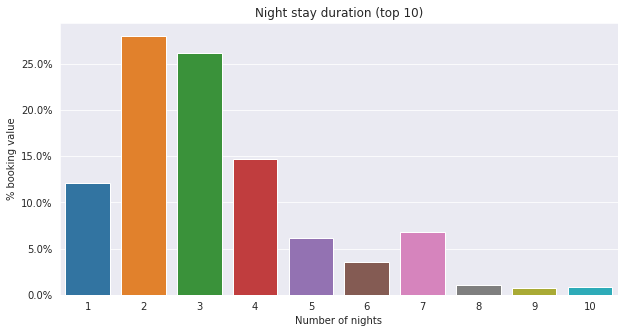

In [21]:
## Przygotowanie danych i generowanie wykresu na temat długości pobytu (nieodwołane)
total_nights = df_not_canceled['stays_in_weekend_nights'] + df_not_canceled['stays_in_week_nights']
x, y = get_count(total_nights, limit = 10)

plot(x, y, x_label = 'Number of nights', y_label = '% booking value', title = 'Night stay duration (top 10)', figsize = (10,5))
## Przewaga rezerwacji na 1, 2, 3 i 4 dni


## Przygotowanie danych i generowanie wykresu na temat długości pobytu (odwołane)
total_nights = df_canceled['stays_in_weekend_nights'] + df_canceled['stays_in_week_nights']
x, y = get_count(total_nights, limit = 10)

plot(x, y, x_label = 'Number of nights', y_label = '% booking value', title = 'Night stay duration (top 10)', figsize = (10,5))
## Mniej rezerwacji odwołanych na 1 dzień wględem nieodwołanych

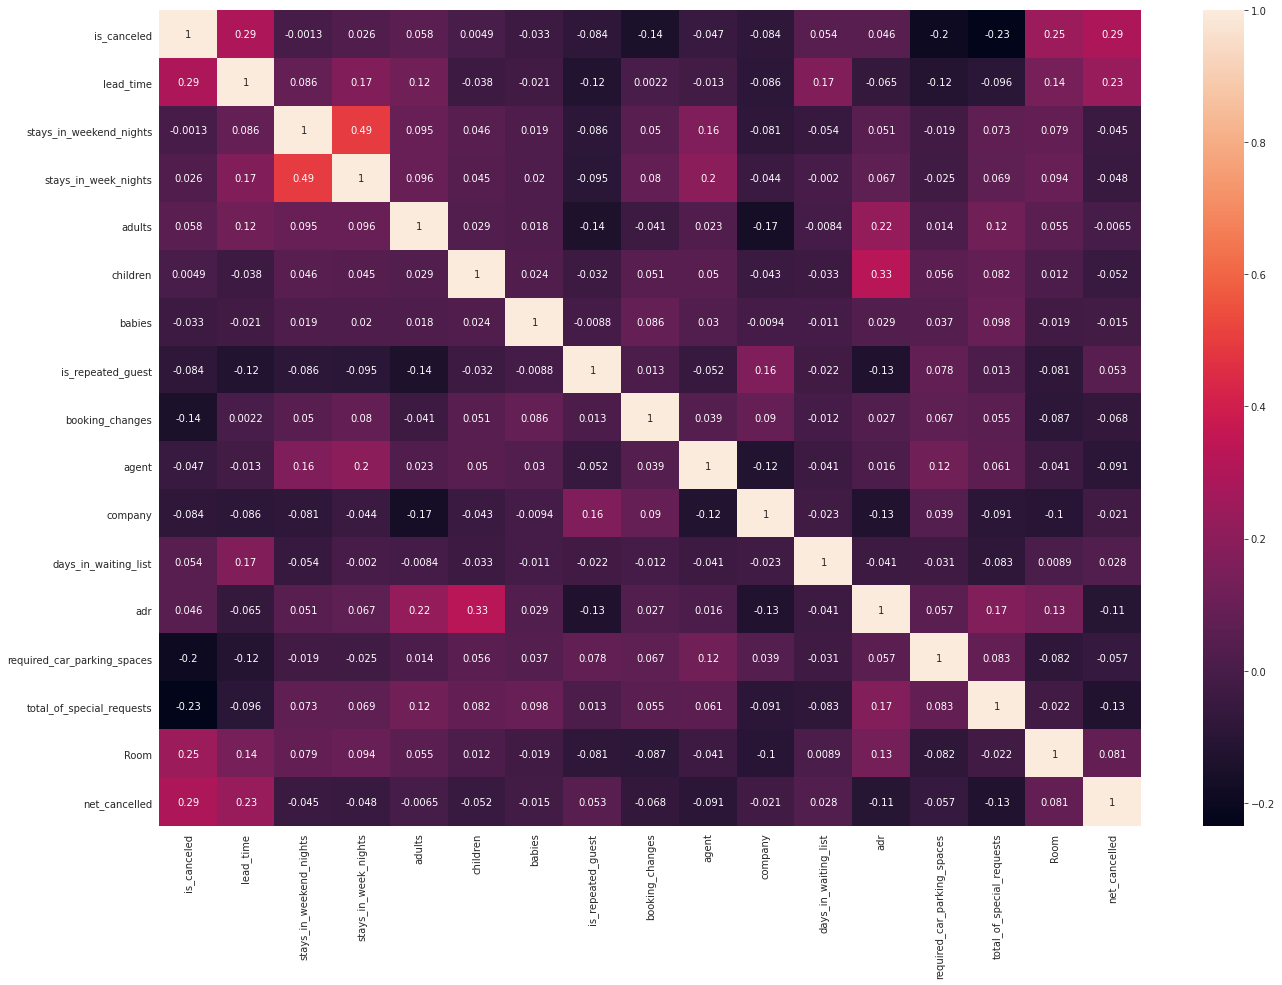

In [22]:
## Kopia datasetu
df_subset = df.copy()

## Stworzenie nowej cechy na podstawie różnic w typie rezerwowanego i otrzymanego pokoju
df_subset['Room'] = 0
df_subset.loc[ df_subset['reserved_room_type'] == df_subset['assigned_room_type'] , 'Room'] = 1

## Stworzenie nowej cechy na podstawie poprzenich anulacji
## Jeśli liczba poprzednich odwołanych rezerwacji jest większa od nieodwołanych rezerwacji to 1, w przeciwnym
## przypadku 0
df_subset['net_cancelled'] = 0
df_subset.loc[ df_subset['previous_cancellations'] > df_subset['previous_bookings_not_canceled'] , 'net_cancelled'] = 1

# Usunięcie niepotrzebnych cech
df_subset = df_subset.drop(['arrival_date_year', 'arrival_date_week_number', 'arrival_date_day_of_month', 'arrival_date_month', 'assigned_room_type', 'reserved_room_type', 'reservation_status', 'reservation_status_date', 'previous_cancellations', 'previous_bookings_not_canceled'], axis=1)

## Heat map
## Interesująca korelacja nowych zmiennych Room i net_cancelled
fig, ax = plt.subplots(figsize=(22,15))
sns.heatmap(df_subset.corr(), annot=True, ax=ax);

# **Klasyfikacja z wykorzystaniem machine learningu**

In [24]:
Data = data1

Data["country"] = Data["country"].replace(np.nan, "unspecified", regex=True)
Data["children"] = Data["children"].replace(np.nan, 0, regex=True)

ToDrop = ["is_canceled","arrival_date_year","arrival_date_week_number","adr","reservation_status","reservation_status_date","agent","company"]
XbeforeEncoding = Data.drop(columns=ToDrop)
y= Data["is_canceled"]
XbeforeEncoding

encoder = OneHotEncoder(sparse=False)
ColsToEncode = XbeforeEncoding[["hotel","arrival_date_month","meal","country","market_segment","distribution_channel","reserved_room_type","assigned_room_type","deposit_type","customer_type"]]
Encoded = encoder.fit_transform(ColsToEncode)
Encoded

array([[0., 1., 0., ..., 0., 1., 0.],
       [0., 1., 0., ..., 0., 1., 0.],
       [0., 1., 0., ..., 0., 1., 0.],
       ...,
       [1., 0., 0., ..., 0., 1., 0.],
       [1., 0., 0., ..., 0., 1., 0.],
       [1., 0., 0., ..., 0., 1., 0.]])

In [26]:
colnames = []
for cat in encoder.categories_[0]:
  colnames.append(f'hotel_{cat}')
for cat in encoder.categories_[1]:
  colnames.append(f'arrival_date_month_{cat}')
for cat in encoder.categories_[2]:
  colnames.append(f'meal_{cat}')
for cat in encoder.categories_[3]:
  colnames.append(f'country_{cat}')
for cat in encoder.categories_[4]:
  colnames.append(f'market_segment_{cat}')
for cat in encoder.categories_[5]:
  colnames.append(f'distribution_channel_{cat}')
for cat in encoder.categories_[6]:
  colnames.append(f'reserved_room_type_{cat}')
for cat in encoder.categories_[7]:
  colnames.append(f'assigned_room_type_{cat}')
for cat in encoder.categories_[8]:
  colnames.append(f'deposit_type_{cat}')
for cat in encoder.categories_[9]:
  colnames.append(f'customer_type_{cat}')

In [30]:
X = pd.DataFrame(Encoded, columns=colnames)
X[["lead_time","arrival_date_day_of_month","stays_in_weekend_nights","stays_in_week_nights","adults","children","babies","is_repeated_guest","previous_cancellations","previous_bookings_not_canceled","booking_changes","days_in_waiting_list","required_car_parking_spaces","total_of_special_requests"]] = XbeforeEncoding[["lead_time","arrival_date_day_of_month","stays_in_weekend_nights","stays_in_week_nights","adults","children","babies","is_repeated_guest","previous_cancellations","previous_bookings_not_canceled","booking_changes","days_in_waiting_list","required_car_parking_spaces","total_of_special_requests"]]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=100)

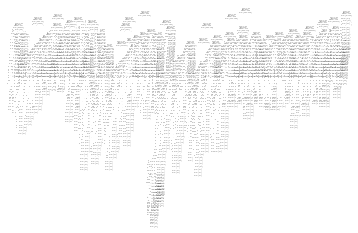

0.8405226568389312

In [92]:
drzewo = DecisionTreeClassifier()
drzewo.fit(X_train, y_train)
plot_tree(drzewo)
plt.show()
pred = drzewo.predict(X_test)
accuracy_score(y_test, pred)

In [ ]:
params={'criterion':['gini', 'entropy'],
       'max_depth':[1, 2, 3, 4, 5,6,7,8,9,10]}
grid = GridSearchCV(estimator=drzewo, 
                    param_grid=params, 
                    verbose=10, 
                    scoring='accuracy',
                   cv=10)
grid.fit(X_train, y_train)
print(grid.best_params_,"  \  ",grid.best_score_)
BestGrid =  grid.best_estimator_
plot_tree(grid.best_estimator_)
plt.show()

In [ ]:
plt.rcParams["figure.figsize"] = (20,20)
feat_importances = pd.Series(BestGrid.feature_importances_, index=X.columns)
feat_importances.nlargest(50).plot(kind='barh')
trainpred = BestGrid.predict(X_train)
testpred = BestGrid.predict(X_test)
print(accuracy_score(y_test, testpred),  /  ,accuracy_score(y_train,trainpred))

In [ ]:
XGBModel = XGBClassifier()
XGBModel.fit(X_train,y_train)
XGBPRED = XGBModel.predict(X_test)
accuracy_score(y_test,XGBPRED)

# **Predykcja z wykorzystaniem Deep learningu**

In [ ]:
def Model():
	model = Sequential()
	model.add(Dense(253, input_dim=253, activation='relu'))
	model.add(Dense(150, activation='relu'))
	model.add(Dense(1, activation='sigmoid'))
	model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
	return model
clf = KerasClassifier(build_fn = Model,epochs = 50, batch_size = 5, verbose = 0)
clf.fit(X_train,y_train)

# **Aplikacja do przewidywania odwołania rezerwacji:**

In [ ]:

Wartości = []
print("Provide hotel type")
TypHotelu = input()
Wartości.append(TypHotelu)

print("provide time")
czas = input()
Wartości.append(czas)

print("provide month")
miesiac = input()
Wartości.append(miesiac)
    
print("provide day of month")
DzieńMiesiaca = input()
Wartości.append(DzieńMiesiaca)

print("Provide nights in weekend")
NoceWeekendowe = input()
Wartości.append(NoceWeekendowe)

print("provide nights in week")
NoceWTygodniu = input()
Wartości.append(NoceWTygodniu)

print("provide adults")
dorośli = input()
Wartości.append(dorośli)

print("provide children")
dzieci = input()
Wartości.append(dzieci)

print("provide babies")
babies = input()
Wartości.append(babies)

print("provide meal")
posilek = input()
Wartości.append(posilek)

print("provide country")
kraj = input()
Wartości.append(kraj)

print("provide Market segment")
segment = input()
Wartości.append(segment)

print("provide distribution channel")
channel = input()
Wartości.append(channel)

print("provide is repeated guest")
guest = input()
Wartości.append(guest)

print("provide previous cancelations")
precancel = input()
Wartości.append(precancel)

print("provide previous bookings not canceled")
prenocancel = input()
Wartości.append(prenocancel)

print("provide reserved room type")
RezTypPokoju = input()
Wartości.append(RezTypPokoju)

print("provide assigned room type")
PrzypTypPokoju = input()
Wartości.append(PrzypTypPokoju)

print("provide booking changes")
Zmiany = input()
Wartości.append(Zmiany)

print("provide deposit type")
depozyt = input()
Wartości.append(depozyt)

print("provide days in waiting list")
DaysWaiting = input()
Wartości.append(DaysWaiting)

print("provide customer type")
typKlienta = input()
Wartości.append(typKlienta)

print("provide required parking spaces")
Parking = input()
Wartości.append(Parking)

print("provide special requests")
SpecReq = input()
Wartości.append(SpecReq)

Dane_Użytkownika = pd.DataFrame([Wartości], columns=XbeforeEncoding.columns)
print(Dane_Użytkownika)

Dane_Użytkownika[["lead_time","arrival_date_day_of_month","stays_in_weekend_nights","stays_in_week_nights","adults","babies","is_repeated_guest","previous_cancellations","previous_bookings_not_canceled","booking_changes","days_in_waiting_list","required_car_parking_spaces","total_of_special_requests"]] = Dane_Użytkownika[["lead_time","arrival_date_day_of_month","stays_in_weekend_nights","stays_in_week_nights","adults","babies","is_repeated_guest","previous_cancellations","previous_bookings_not_canceled","booking_changes","days_in_waiting_list","required_car_parking_spaces","total_of_special_requests"]].astype("int64")
Dane_Użytkownika["children"] = Dane_Użytkownika["children"].astype("float64")
print(Dane_Użytkownika.info())

XbeforeEncoding = XbeforeEncoding.append(Dane_Użytkownika, ignore_index=True)
encoder = OneHotEncoder(sparse=False)
ColsToEncode = XbeforeEncoding[["hotel","arrival_date_month","meal","country","market_segment","distribution_channel","reserved_room_type","assigned_room_type","deposit_type","customer_type"]]
UEncoded = encoder.fit_transform(ColsToEncode)
UEncoded

colnames = []
for cat in encoder.categories_[0]:
  colnames.append(f'hotel_{cat}')
for cat in encoder.categories_[1]:
  colnames.append(f'arrival_date_month_{cat}')
for cat in encoder.categories_[2]:
  colnames.append(f'meal_{cat}')
for cat in encoder.categories_[3]:
  colnames.append(f'country_{cat}')
for cat in encoder.categories_[4]:
  colnames.append(f'market_segment_{cat}')
for cat in encoder.categories_[5]:
  colnames.append(f'distribution_channel_{cat}')
for cat in encoder.categories_[6]:
  colnames.append(f'reserved_room_type_{cat}')
for cat in encoder.categories_[7]:
  colnames.append(f'assigned_room_type_{cat}')
for cat in encoder.categories_[8]:
  colnames.append(f'deposit_type_{cat}')
for cat in encoder.categories_[9]:
  colnames.append(f'customer_type_{cat}')

XU = pd.DataFrame(UEncoded, columns=colnames)
XU[["lead_time","arrival_date_day_of_month","stays_in_weekend_nights","stays_in_week_nights","adults","children","babies","is_repeated_guest","previous_cancellations","previous_bookings_not_canceled","booking_changes","days_in_waiting_list","required_car_parking_spaces","total_of_special_requests"]] = XbeforeEncoding[["lead_time","arrival_date_day_of_month","stays_in_weekend_nights","stays_in_week_nights","adults","children","babies","is_repeated_guest","previous_cancellations","previous_bookings_not_canceled","booking_changes","days_in_waiting_list","required_car_parking_spaces","total_of_special_requests"]]
XU

print("probability of cancel in this case is equal to ")
model.predict_proba(XU.iloc[-1:])

    